==========Pumping Cycle Tresholds Results==========
Mean = 9.070960331895426 Pa



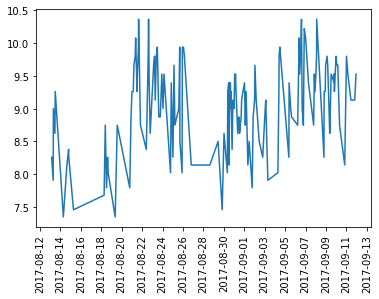

==========Pumping Cycle Health Analysis Results==========


,Correlation,P-Value
0,-0.812386,0.000428
1,-0.783807,0.001510
2,-0.783408,0.000433
3,-0.810932,0.000271
4,-0.780917,0.000416
...,...,...
148,-0.765361,0.000567
149,-0.830086,0.000553
150,-0.749418,0.000482
151,-0.789323,0.000631


In [2]:
import pandas as pd
from pumping_cycle_utils import populate_tresholds, populate_statistics, append_dataframe

df = pd.read_csv("Pressure.csv")
df["Date"] = pd.to_datetime(df["Date"])

print("{0}Pumping Cycle Tresholds Results{0}".format("="*10))
append_dataframe(df,start_time_offset=10,end_time_offset=-5) #Add 2 new columns to original DF
populate_tresholds(dataframe=df)

print("{0}Pumping Cycle Health Analysis Results{0}".format("="*10))
#Show Kendalls Tau and p-value for all pump cycles
populate_statistics(dataframe=df)